# Trees. Random Forest

Rules:

- The homework is graded out of 10 points (+1 bonus point).
- You may use without proof any results covered in the course lectures or seminars, unless deriving those results is explicitly part of a question.
- You may use any open sources, but you must include a reference to them.

**CONSENT**.
<input type="checkbox" enabled checked /> I confirm that I will use AI agents in this home assignment only on the condition that they are documented.

![mem.png](https://github.com/karpovmax/images_python_teaching/blob/main/meme.jpg?raw=true)

## Part 1: Basics of Building a Decision Tree (1.5 points)

In this part all calculations must be implemented as programmed formulas (e.g., using `numpy`). **You may not use ready-made implementations**. For example, if a task asks you to compute entropy, you must implement the formula yourself in some form, but you may not call a ready-made `some_module.entropy()`.


In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

**Task 1.1 (0.5 points)** Suppose 10 objects reach a node of a decision tree: 8 have class label $k_1$ and 2 have class label $k_2$. Compute the entropy of this class distribution (using the natural logarithm). Round your answer to two decimals.

In [ ]:
p1 = 2/10
p2 = 8/10

entropy = -(p1*np.log(p1) + p2*np.log(p2))
entropy.round(2)

np.float64(0.5)

**Task 1.2 (0.5 points)** Suppose further that the node from the previous task is not a leaf, and there exists a split such that all objects of class $k_1$ go to the left subtree and all objects of class $k_2$ go to the right subtree. Compute the information criterion:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

where $R_m$ is the set of objects in the node being split, $j$ is the index of the feature used for the split, $t$ is the split threshold, $R_\ell$ is the set of objects in the left subtree, and $R_r$ is the set of objects in the right subtree.

Now let $H(R)$ be the Gini index:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
where $J$ is the total number of classes (in our case, $J = 2$).

Round your answer to two decimals.

In [ ]:
counts = np.array([8, 2])
p = counts / counts.sum()
H_Rm = np.sum(p * (1 - p))

counts = np.array([0, 2])
p = counts / counts.sum()
H_Rr = np.sum(p * (1 - p))

counts = np.array([8, 0])
p = counts / counts.sum()
H_Rl = np.sum(p * (1 - p))

Q = H_Rm - H_Rl * 8/10 - H_Rr * 2/10
np.round(Q, 2)

np.float64(0.32)

**Task 1.3 (0.5 points)** Suppose a leaf node formed during tree construction contains 10 objects with the following target values (regression task): [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]. What will the model’s predictions be for these objects?

In [ ]:
targets = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
targets.mean()

np.float64(40.6)

## Part 2: Decision Trees (4.5 points)

In this part we will write and test our own decision tree implementation.

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union, Optional

**Task 2.1 (1.5 points)** Implement the function `find_best_split()` that finds the optimal split of a subset of the
training set according to the information gain Q from **Task 1.2**:
Q = H(parent) − w_left * H(left) − w_right * H(right), and we **maximize** Q.

- For **classification**, use **Gini** as the impurity H.
- For **regression**, use the **population variance** of the target as H.
- For **real-valued** features, candidate thresholds are the midpoints between adjacent **distinct** sorted values.
  Do **not** consider thresholds that would send an empty child.
- For **categorical** (integer-encoded) features, use a naive split: for every category value `c`, split by `(x == c)`
  vs `(x != c)` and pick the one that maximizes Q.
- If multiple candidates give the same maximal Q, choose the **smallest threshold** (or smallest category value).

You may use hints from the decision trees seminar.

**Bonus:** An implementation that avoids explicit Python loops over thresholds (i.e., vectorized) earns **+1 bonus point**.


In [ ]:
def gini(target_vector):
  p = np.bincount(target_vector)/len(target_vector)

  return np.sum(p * (1-p))

def variance(target_vector):
  mean_target = np.mean(target_vector)

  return np.sum((target_vector - mean_target)**2)/len(target_vector)

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.Series],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, Optional[float], float]:
    """
    Instructions:
    * Do not consider thresholds that would send an empty set of objects to one of the subtrees.
    * For real features, use the midpoint between adjacent **distinct** sorted values as candidate thresholds.
    * Behavior for a constant feature may be arbitrary (no valid split).
    * If multiple candidates yield equal **information gain Q**, choose the minimal split (smallest threshold/category).
    * Prefer vectorization where reasonable.

    :param feature_vector: 1D array of a single feature's values (real-valued or integer-encoded categories)
    :param target_vector:  1D array of targets; len(feature_vector) == len(target_vector)
    :param task:           'classification' or 'regression'
    :param feature_type:   'real' or 'categorical'

    :return thresholds_or_cats: np.ndarray of all candidate thresholds (real) or categories (categorical)
    :return gains:              np.ndarray of **information gains Q** for each candidate (same length as above)
    :return best_threshold:     the optimal threshold/category (float or int); or None if no valid split
    :return best_gain:          the maximal information gain Q (float; 0.0 if no valid split)
    """

    match task:
      case "classification":
        H = gini
      case "regression":
        H = variance


    thresholds_or_cats = []
    gains = []
    best_threshold = None
    best_gain = 0.0

    match feature_type:
      case "real":
        idx = np.argsort(feature_vector)
        feature_vector = feature_vector[idx]
        target_vector = target_vector[idx]

        unique_feature_vector = np.unique(feature_vector)

        potential_thresholds = (unique_feature_vector[:-1] + unique_feature_vector[1:]) / 2

        target_H = H(target_vector)

        for potential_threshold in potential_thresholds:
          left_mask = feature_vector <= potential_threshold
          right_mask = feature_vector > potential_threshold

          left_vector = feature_vector[left_mask]
          right_vector = feature_vector[right_mask]

          left_targets = target_vector[left_mask]
          right_targets = target_vector[right_mask]

          if len(left_vector) == 0 or len(right_vector) == 0:
            continue

          Q = target_H - (len(left_targets)/len(target_vector)) * H(left_targets) - (len(right_targets)/len(target_vector)) * H(right_targets)

          gains.append(Q)
          thresholds_or_cats.append(potential_threshold)

          if Q > best_gain:
            best_gain = Q
            best_threshold = potential_threshold

      case "categorical":
        potential_thresholds = np.unique(feature_vector)

        target_H = H(target_vector)

        for potential_threshold in potential_thresholds:
          left_mask = feature_vector == potential_threshold
          right_mask = feature_vector != potential_threshold

          left_vector = feature_vector[left_mask]
          right_vector = feature_vector[right_mask]

          left_targets = target_vector[left_mask]
          right_targets = target_vector[right_mask]

          if len(left_vector) == 0 or len(right_vector) == 0:
            continue

          Q = target_H - (len(left_targets)/len(target_vector)) * H(left_targets) - (len(right_targets)/len(target_vector)) * H(right_targets)

          gains.append(Q)
          thresholds_or_cats.append(potential_threshold)

          if Q > best_gain:
            best_gain = Q
            best_threshold = potential_threshold


    return np.array(thresholds_or_cats), np.array(gains), best_threshold, best_gain

You can test this function on the **California Housing** dataset from `sklearn`

In [ ]:
from sklearn.datasets import fetch_california_housing
cal = fetch_california_housing(as_frame=True)
X = cal.frame.drop(columns=["MedHouseVal"])
y = cal.frame["MedHouseVal"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["MedInc"].to_numpy(),
    y,
    task="regression",
    feature_type="real"
)

Plot the dependence of the error criterion value on the threshold when splitting a node by the `MedInc` feature.

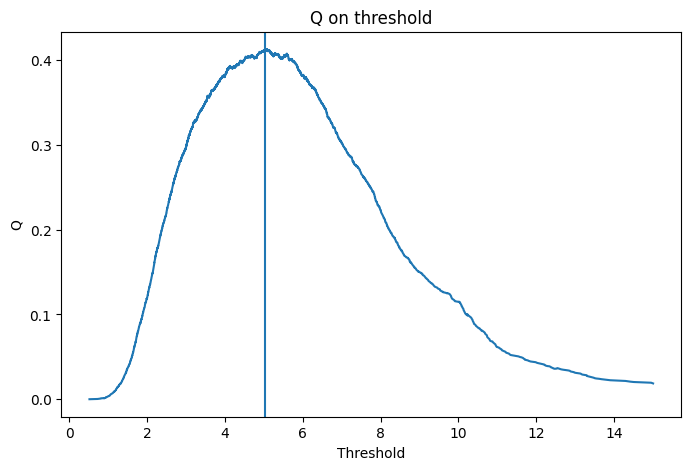

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, variances)
plt.axvline(threshold_best)
plt.xlabel("Threshold")
plt.ylabel("Q")
plt.title("Q on threshold")
plt.show()

**Task 2.2 (1 point)** Study the provided decision tree code, fill in the missing parts, and implement `_predict_node()`.

Tree construction follows the basic greedy algorithm.
- **Best split selection:** choose the split that maximizes information gain Q using Gini as the impurity for classification.
- **Stopping criteria:** all objects in a node share the same class, or no feature allows a valid split (respecting any min-samples settings), or the maximum depth is reached (if specified).
- **Leaf prediction:** the most frequent class in the leaf.


In [ ]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # We will store the decision tree nodes in this variable. Each node stores an identifier of whether it is a leaf.
        # Leaf nodes store the predicted class value; non-leaf nodes store the left and right children (subtrees for
        # continuing the prediction procedure).
        self._tree = {}

        # feature types (categorical or numerical)
        self._feature_types = feature_types

        # tree hyperparameters
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict,
        depth: int = 0
    ) -> None:

        # stopping criterion
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        if self._max_depth is not None and depth >= self._max_depth:
          node["type"] = "terminal"
          node["class"] = Counter(sub_y).most_common(1)[0][0]
          return

        if self._min_samples_split is not None and len(sub_y) < self._min_samples_split:
          node["type"] = "terminal"
          node["class"] = Counter(sub_y).most_common(1)[0][0]
          return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # prepare the feature for searching the optimal threshold
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # a more sophisticated approach to categorical features could be implemented here
                feature_vector = sub_X[:, feature]


            # search for the optimal threshold
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if threshold is None:
              continue

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split — a mask for the objects that should go to the left subtree
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold_best
                elif feature_type == "categorical":
                    # in this implementation, this is simply the category value
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        # write the resulting splits to the class attributes
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        left_X, left_y = sub_X[split], sub_y[split]
        right_X, right_y = sub_X[~split], sub_y[~split]

        if self._min_samples_leaf is not None:
          if len(left_y) < self._min_samples_leaf or len(right_y) < self._min_samples_leaf:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return


        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"], depth + 1)
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"], depth + 1)

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Prediction starts at the root node and recursively proceeds to the left or right subtree depending on the
        predicate’s value on the object. A leaf node returns the prediction.
        :param x: np.array, a sample element
        :param node: dict, a tree node
        """

        if node["type"] == "terminal":
            return node["class"]

        feature = node["feature_split"]
        ftype = self._feature_types[feature]

        if ftype == "real":
            if x[feature] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            if x[feature] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Task 2.3 (1 point)** Load the `students.csv` table (a slightly modified
[User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling) dataset).
The object features are in the first five columns, and the target variable (class: 0 or 1) is in the last column.

On a single figure, plot five “threshold (or category) - information gain (Gini)” curves:
- For real-valued features: scan thresholds as in Task 2.1 and plot a smooth curve of Q vs threshold.
- For categorical features (integer-encoded): try each category split `(x == c)` vs `(x != c)` and plot Q as stem markers against category values.

Separately, visualize scatter plots of “feature value — class” for all five features.

Then answer:
- Based on the gain curves, which feature would you split on first?
- Does this agree with the visual assessment of the scatter plots?
- How do “good” features (near-perfect separators) look in the gain curves vs “poor” features?


In [ ]:
df = pd.read_csv("students.csv").drop("Unnamed: 0", axis=1)
df

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,1
254,0.78,0.61,0.71,0.19,0.60,1
255,0.54,0.82,0.71,0.29,0.77,1
256,0.50,0.75,0.81,0.61,0.26,1


In [ ]:
X = df.drop("UNS", axis=1)
X

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24
...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58
254,0.78,0.61,0.71,0.19,0.60
255,0.54,0.82,0.71,0.29,0.77
256,0.50,0.75,0.81,0.61,0.26


In [ ]:
y = df["UNS"]
y

,UNS
0,0
1,1
2,0
3,1
4,0
...,...
253,1
254,1
255,1
256,1


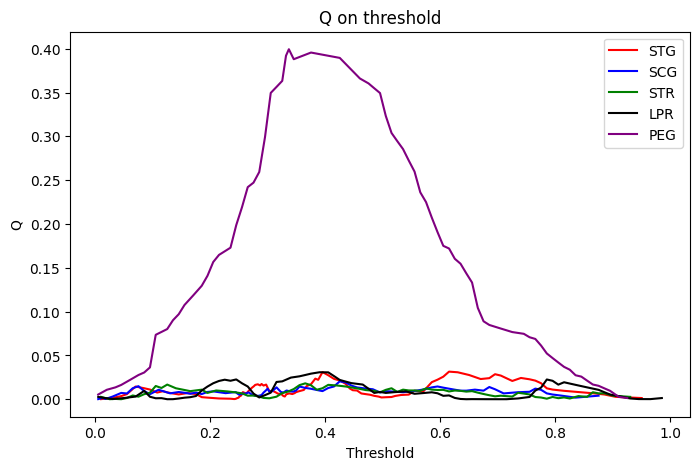

In [ ]:
plt.figure(figsize=(8, 5))

thresholds, variances, threshold_best, variance_best = find_best_split(X["STG"].to_numpy(),y.to_numpy().flatten(),task="classification",feature_type="real")
plt.plot(thresholds, variances, color="red", label="STG")

thresholds, variances, threshold_best, variance_best = find_best_split(X["SCG"].to_numpy(),y.to_numpy().flatten(),task="classification",feature_type="real")
plt.plot(thresholds, variances, color="blue", label="SCG")

thresholds, variances, threshold_best, variance_best = find_best_split(X["STR"].to_numpy(),y.to_numpy().flatten(),task="classification",feature_type="real")
plt.plot(thresholds, variances, color="green", label="STR")

thresholds, variances, threshold_best, variance_best = find_best_split(X["LPR"].to_numpy(),y.to_numpy().flatten(),task="classification",feature_type="real")
plt.plot(thresholds, variances, color="black", label="LPR")

thresholds, variances, threshold_best, variance_best = find_best_split(X["PEG"].to_numpy(),y.to_numpy().flatten(),task="classification",feature_type="real")
plt.plot(thresholds, variances, color="purple", label="PEG")

plt.xlabel("Threshold")
plt.ylabel("Q")
plt.title("Q on threshold")
plt.legend()
plt.show()


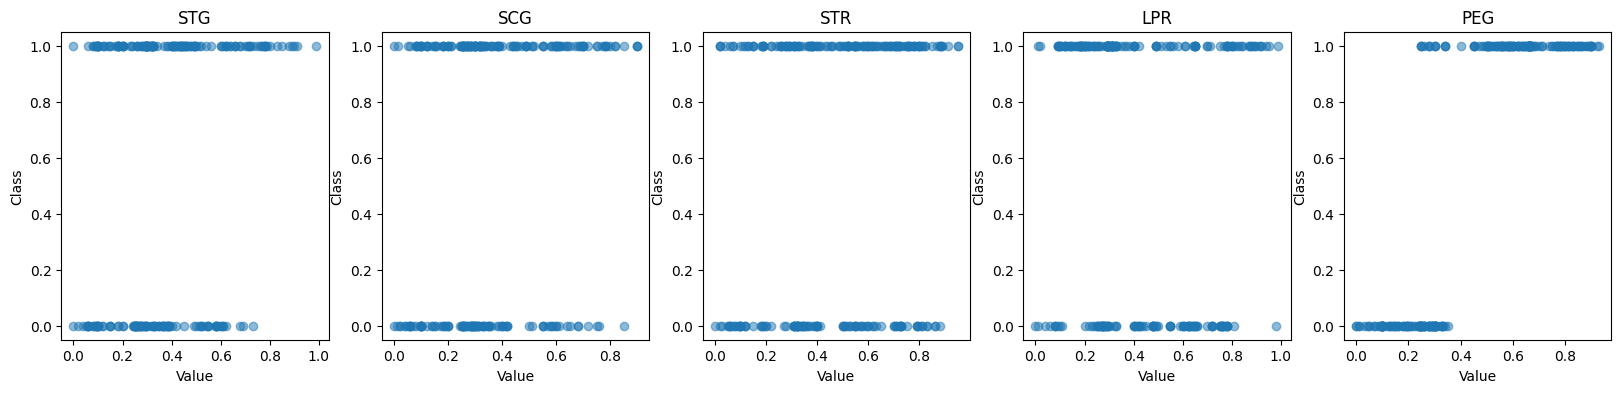

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(X.columns):
    axes[i].scatter(X[col], y, alpha=0.5)
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Class")
plt.show()

Based on the gain curves, which feature would you split on first?
PEG feature has the biggest Q so better it use it

Does this agree with the visual assessment of the scatter plots?
Yeah, in PEG scatter plot there is a visible split between values

How do “good” features (near-perfect separators) look in the gain curves vs “poor” features?
Good features has increasing, peak and decreasing. Bad features have flat plots.


**Task 2.4 (1 point)** Test your decision tree on the
[mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) dataset.

1. Download `agaricus-lepiota.data` (from the
   [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)).
2. Read the table using `pandas`.
3. Apply `LabelEncoder` (from `sklearn`) to each column to transform string categories into integers.

The first column is the target (e — edible, p — poisonous). Measure quality using accuracy (it doesn't matter which class is 1).
Split the data 50/50 into train/test using a fixed `random_state` and stratification.
Train your decision tree (treat all features as categorical in your implementation) and compute accuracy on the test set.


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

mushroom = fetch_ucirepo(id=73)

X = mushroom.data.features
y = mushroom.data.targets
X

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,...,s,o,o,p,o,o,p,b,c,l
8120,x,s,n,f,n,a,c,b,y,e,...,s,o,o,p,n,o,p,b,v,l
8121,f,s,n,f,n,a,c,b,n,e,...,s,o,o,p,o,o,p,b,c,l
8122,k,y,n,f,y,f,c,n,b,t,...,k,w,w,p,w,o,e,w,v,l


In [ ]:
y

,poisonous
0,p
1,e
2,e
3,p
4,e
...,...
8119,e
8120,e
8121,e
8122,p


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

X = X.apply(le.fit_transform).values
y = y.apply(le.fit_transform).values.ravel()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=42,stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4062, 22), (4062, 22), (4062,), (4062,))

In [ ]:
tree = DecisionTree(["categorical"]*22)

In [ ]:
tree.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, tree.predict(X_test))

1.0

## Part 3: Bagging and Random Forest (4 points)

In this part we will work with the [patient diabetes prediction task](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). We will examine bagging over decision trees and random forests and compare their performance.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "diabetes.csv"

data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "uciml/pima-indians-diabetes-database",
  file_path)

data.head()

/tmp/ipython-input-1080824613.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  data = kagglehub.load_dataset(


Using Colab cache for faster access to the 'pima-indians-diabetes-database' dataset.


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Let’s look at the target variable distribution

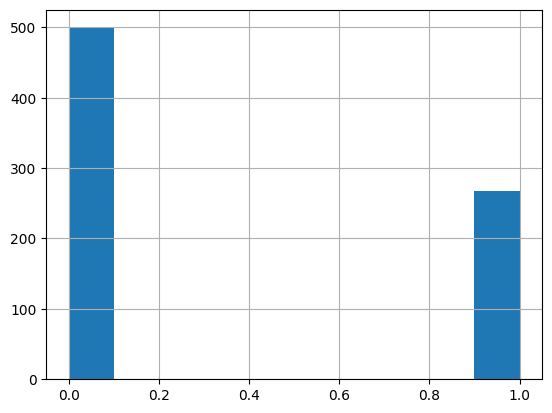

In [ ]:
data['Outcome'].hist()
plt.show()

**Task 3.1 (0.5 points)** Split the data into features and target. Split the dataset into **training** and **test**
parts in a 7:3 ratio using a fixed `random_state` and **stratify=y**. Then split the training set into
training–training and training–validation in a 7:3 ratio (also stratified). You should end up with three sets:
training–training (0.49 of the original dataset), training–validation (0.21), and test (0.30).


In [ ]:
X = data.drop("Outcome", axis=1).values
y = data["Outcome"].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train,y_train,test_size=0.3,random_state=42,stratify=y_train)

**Task 3.2 (1 point)** On the training–validation set, tune `max_depth` and `min_samples_leaf` for `DecisionTreeClassifier`. To do this:
1. Create lists of possible values to search over.
2. For each pair, train a tree on the training–training set and evaluate quality on the training–validation set. Use the `F1-score` as the criterion.
3. Choose the pair that gives the highest `F1-score` on the training–validation set.

Train a decision tree with the selected hyperparameters on the **full training** set. Evaluate classification quality on the test set using the metrics `accuracy`, `precision`, `recall`, and `ROC AUC`.

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
from tqdm import tqdm

best_f1 = 0
best_max_depth = 1
best_min_samples_leaf = 1

for max_depth in tqdm(range(21, 1, -1)):
  for min_samples_leaf in range(1, 21):
    tree = DecisionTree(["real"]*8, max_depth, min_samples_leaf)

    tree.fit(X_train_train, y_train_train)

    f1 = f1_score(y_train_val, tree.predict(X_train_val))

    if f1 > best_f1:
      best_f1 = f1
      best_max_depth = max_depth
      best_min_samples_leaf = min_samples_leaf

print(best_f1, best_max_depth, best_min_samples_leaf)

100%|██████████| 20/20 [01:44<00:00,  5.24s/it]

0.5486725663716814 5 1


In [ ]:
tree = DecisionTree(["real"]*8, best_max_depth, best_min_samples_leaf)
tree.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

In [ ]:
y_pred = tree.predict(X_test)

In [ ]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("RocAuc: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))

Accuracy:  0.7705627705627706
Recall:  0.4444444444444444
Precision:  0.8181818181818182
RocAuc:  0.6955555555555556
F1:  0.576


**Task 3.3 (0.5 points)** Train a [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) with 50 trees on the **full training** set. Evaluate classification quality on the test set using the same metrics.

Its too boring to use tree from scikit learn, so Ill modify my tree:

In [ ]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # We will store the decision tree nodes in this variable. Each node stores an identifier of whether it is a leaf.
        # Leaf nodes store the predicted class value; non-leaf nodes store the left and right children (subtrees for
        # continuing the prediction procedure).
        self._tree = {}

        # feature types (categorical or numerical)
        self._feature_types = feature_types

        # tree hyperparameters
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task


    def get_params(self, deep: bool = True):
        return {
            "feature_types": self._feature_types,
            "max_depth": self._max_depth,
            "min_samples_split": self._min_samples_split,
            "min_samples_leaf": self._min_samples_leaf,
            "task": self.task,
        }


    def set_params(self, **params):
        for key, value in params.items():
            if key == "feature_types":
                self._feature_types = value
            elif key == "max_depth":
                self._max_depth = value
            elif key == "min_samples_split":
                self._min_samples_split = value
            elif key == "min_samples_leaf":
                self._min_samples_leaf = value
            elif key == "task":
                self.task = value
        return self


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict,
        depth: int = 0
    ) -> None:

        # stopping criterion
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        if self._max_depth is not None and depth >= self._max_depth:
          node["type"] = "terminal"
          node["class"] = Counter(sub_y).most_common(1)[0][0]
          return

        if self._min_samples_split is not None and len(sub_y) < self._min_samples_split:
          node["type"] = "terminal"
          node["class"] = Counter(sub_y).most_common(1)[0][0]
          return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # prepare the feature for searching the optimal threshold
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # a more sophisticated approach to categorical features could be implemented here
                feature_vector = sub_X[:, feature]


            # search for the optimal threshold
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if threshold is None:
              continue

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split — a mask for the objects that should go to the left subtree
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold_best
                elif feature_type == "categorical":
                    # in this implementation, this is simply the category value
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        # write the resulting splits to the class attributes
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        left_X, left_y = sub_X[split], sub_y[split]
        right_X, right_y = sub_X[~split], sub_y[~split]

        if self._min_samples_leaf is not None:
          if len(left_y) < self._min_samples_leaf or len(right_y) < self._min_samples_leaf:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return


        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"], depth + 1)
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"], depth + 1)

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Prediction starts at the root node and recursively proceeds to the left or right subtree depending on the
        predicate’s value on the object. A leaf node returns the prediction.
        :param x: np.array, a sample element
        :param node: dict, a tree node
        """

        if node["type"] == "terminal":
            return node["class"]

        feature = node["feature_split"]
        ftype = self._feature_types[feature]

        if ftype == "real":
            if x[feature] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            if x[feature] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)


In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
tree = DecisionTree(
    feature_types=["real"]*8,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1
)

bagging_ensemble = BaggingClassifier(tree, n_estimators=50)
bagging_ensemble.fit(X_train, y_train,)
y_pred = bagging_ensemble.predict(X_test)


print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("RocAuc: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))

Accuracy:  0.7619047619047619
Recall:  0.5432098765432098
Precision:  0.7096774193548387
RocAuc:  0.711604938271605
F1:  0.6153846153846154


**Task 3.4 (1 point)** Perform cross-validation on the full training set and tune `max_depth` and `min_samples_split` for a `Random Forest` with 50 trees. To do this:

1. Create lists of possible values to search over.
2. For each pair, perform cross-validation on the full training set. Choose the number of folds at your discretion. Use the `F1-score` as the criterion. Average the criterion over all cross-validation runs.
3. Choose the pair that gives the best average quality.

Train a random forest with the selected hyperparameters on the **full training** set. Evaluate classification quality using the same metrics. Which of the three models performed best?

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

In [ ]:
best_f1 = 0
best_max_depth = 1
best_min_samples_leaf = 1

for max_depth in tqdm(range(21, 1, -1)):
  for min_samples_leaf in range(1, 5):
    f1_scores = []
    for train_index, val_index in kf.split(X_train):
      X_train_cross, X_val_cross = X_train[train_index], X_train[val_index]
      y_train_cross, y_val_cross = y_train[train_index], y_train[val_index]

      rf = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
      rf.fit(X_train_cross, y_train_cross)

      f1_scores.append(f1_score(y_val_cross,rf.predict(X_val_cross)))

    f1 = sum(f1_scores)/len(f1_scores)

    if f1 > best_f1:
      best_f1 = f1
      best_max_depth = max_depth
      best_min_samples_leaf = min_samples_leaf


100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


In [ ]:
print(best_f1, best_max_depth, best_min_samples_leaf)

0.6379114004653532 11 1


In [ ]:
rf = RandomForestClassifier(n_estimators=50, max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, n_estimators=50)

In [ ]:
y_pred = rf.predict(X_test)


print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("RocAuc: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))

Accuracy:  0.935064935064935
Recall:  0.8765432098765432
Precision:  0.9342105263157895
RocAuc:  0.921604938271605
F1:  0.9044585987261147


Metrics of the Random forest are much better than bagging or just one tree

**Task 3.5 (0.5 points)** Plot the dependence of ROC AUC on the test set versus the number of trees (`n_estimators`) for a random forest trained on the **full training** set. What conclusions can be drawn?

In [ ]:
results = []

for n_estimators in tqdm(range(300, 0, -1)):
  rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)
  rf.fit(X_train, y_train)

  results.append(roc_auc_score(y_test, rf.predict(X_test)))

100%|██████████| 300/300 [02:38<00:00,  1.89it/s]


/tmp/ipython-input-1799202167.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


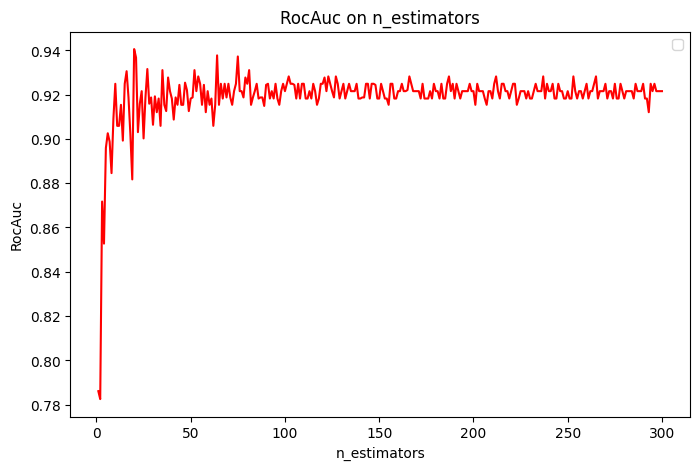

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(list(range(300,0,-1)), results, color="red")

plt.ylabel("RocAuc")
plt.xlabel("n_estimators")
plt.title("RocAuc on n_estimators")
plt.legend()
plt.show()


RocAuc grows with n_estimators until ~20-25, then score stops and just fluctuates near one number. More n_estimators means more memory and time so there is no reason to increase the value

**Task 3.6 (0.5 points)** For the best random forest model from **Task 3.4**, compute feature importances and build a bar plot. Which feature turned out to be the most important for determining diabetes?

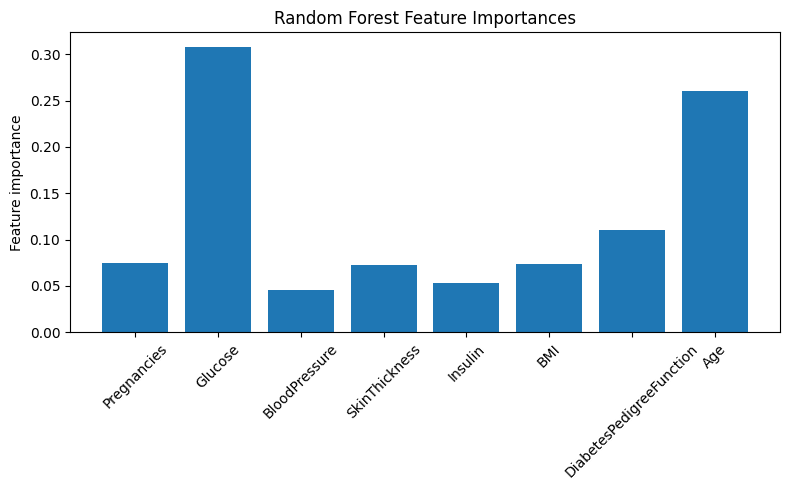

In [ ]:
importances = rf.feature_importances_
features = list(data.columns)[:-1]

plt.figure(figsize=(8, 5))
plt.bar(features, importances)
plt.xticks(rotation=45)
plt.ylabel("Feature importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

Glucose seems to be the most important feature, I get this results from trained rf model, so glucese is the most important feature for determining diabetes

---

**When using AI, chatbots, generative and large language models** (ChatGPT, DeepSeek, Qwen, Mistral/Mixtral, Microsoft Copilot, Gemini, Claude, Grok, YandexGPT, GigaChat and others), **you must specify the following for each of them in LLM Documentation in the next cell**:
- The full name and version of the model, as well as a link to the service used
   * The application or browser version with built-in assistant, TG bot, etc.
- **All** used prompts
- Tell us how you rate the AI's work, and what specific problem did it help solve?
- The verdict on recognizing the decision as written by AI without observing these rules is made by a teaching team.
   * Such cases are to be considered as plagiarism.


<font color=green><h4><b>LLM Documentation if used</b></h4></font>
<font color=red><b>ChatGPT 5.1 Thinking/Instant chatgpt.com browser version

I used it to find help bugs and weak places. Like: "Analyse the code, is everything ok: code"

Like replace of google: "How this formula works? formula", "How to get sordes idx from numpy array", "How to use this class of tree like an estimator for scikit learn Bagging?

AI always helps to solve some 1-2 steps tasks and do it perfect. It cannot make some complex task good"</b></font>
